### Imports

In [1]:
# !pip install 'tf-nightly'
# !pip install 'tensorflow_hub'

In [2]:
import tensorflow as tf

2024-02-25 18:58:41.444583: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-25 18:58:50.212506: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-25 18:58:50.233532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 18:59:09.935167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [8]:

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Part 1: Use TensorFlow Hub MobileNet for prediction

#### Download the classifier

In [9]:
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

IMG_SHAPE = 224

model = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape = (IMG_SHAPE, IMG_SHAPE, 3))
])

### Run it on single image

In [10]:
import PIL.Image as Image
import numpy as np

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMG_SHAPE, IMG_SHAPE))

In [11]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [12]:
result = model.predict(grace_hopper[np.newaxis, ...])

1/1 [==============================] - 2s 2s/step


In [13]:
predicted_class = np.argmax(result[0], axis = -1)
predicted_class

653

### Decode the predictions

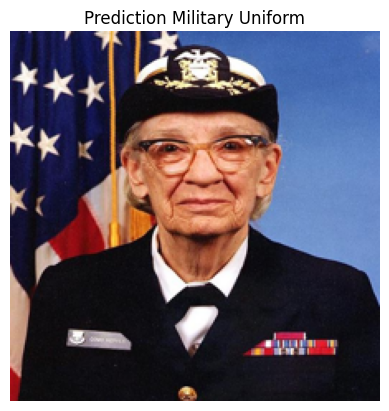

In [14]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
pred_class_name = imagenet_labels[predicted_class]
_  = plt.title("Prediction " + pred_class_name.title())

## Part 2: Use a TensorFlow Hub models for the cats vs dogs dataset

### Load Dataset

In [ ]:
(train_examples, val_examples) , info = tfds.load('cats_vs_dogs', with_info  = True, split=['train[:80%]', 'train[80%:]'], as_supervised = True)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

2024-02-25 19:06:01.333562: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Images are not in the same size

In [9]:
for i, image in enumerate(train_examples.take(3)):
    print("Image: {} Shape: {}".format(i+1, image[0].shape))

Image: 1 Shape: (262, 350, 3)
Image: 2 Shape: (409, 336, 3)
Image: 3 Shape: (493, 500, 3)


#### Reformat all images to imagenet shape

In [8]:
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE)) / 255.0
    return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
val_batches = val_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

### Run the classifier on batch of images

In [18]:
image_batch, label_batch = next(iter(train_batches.take(1)))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

results = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(results, axis = -1)]
predicted_class_names

1/1 [==============================] - 0s 29ms/step


array(['Weimaraner', 'tabby', 'schipperke', 'English foxhound',
       'Persian cat', 'tabby', 'keeshond', 'Tibetan mastiff', 'tabby',
       'kelpie', 'Labrador retriever', 'Siamese cat', 'Egyptian cat',
       'cairn', 'Egyptian cat', 'Eskimo dog', 'Egyptian cat',
       'German short-haired pointer', 'pug',
       'American Staffordshire terrier', 'redbone', 'Chihuahua',
       'Egyptian cat', 'schipperke', 'Brittany spaniel',
       'flat-coated retriever', 'Angora', 'schipperke', 'Eskimo dog',
       'Egyptian cat', 'Egyptian cat', 'English setter'], dtype='<U30')

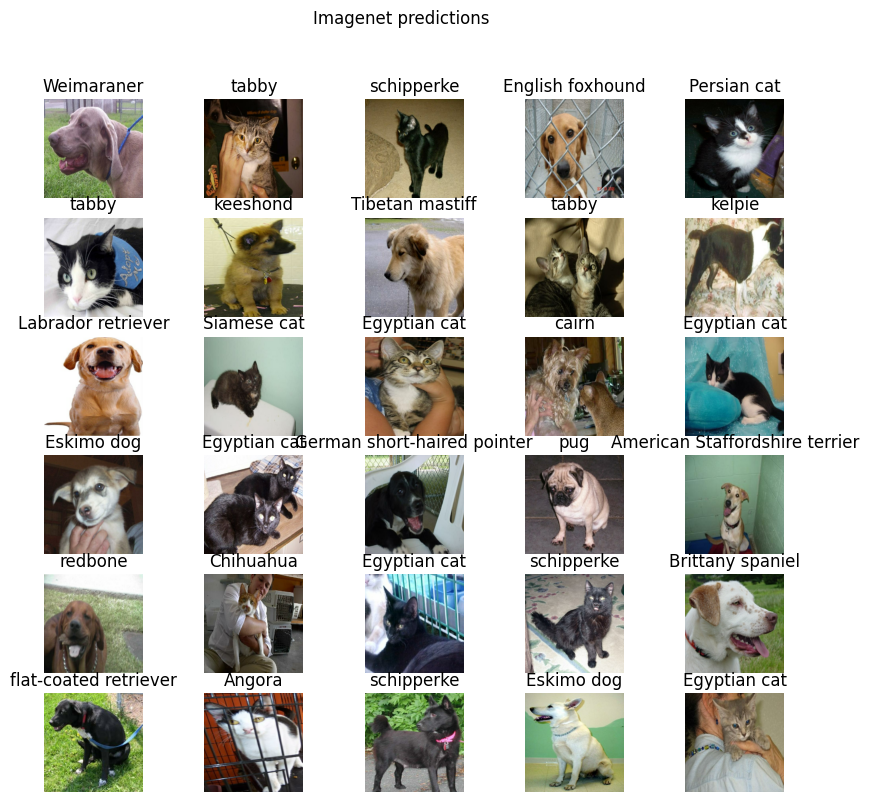

In [19]:
plt.figure(figsize = (10, 9))

for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle('Imagenet predictions')

## Part 3: Do simple transfer learning with Tensorflow Hub

In [20]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
features_extractor  = hub.KerasLayer(url,
                                    input_shape = (IMG_SHAPE, IMG_SHAPE, 3))

In [21]:
feature_batch = features_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [22]:
features_extractor.trainable = False

### Attach a classification head

In [23]:
model = tf.keras.Sequential([
    features_extractor,
    layers.Dense(2, activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


### Train the model

In [25]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

EPOCHS = 2

history = model.fit(train_batches,
                   epochs = EPOCHS,
                   validation_data = val_batches)

Epoch 1/2
582/582 [==============================] - 55s 83ms/step - loss: 0.0272 - accuracy: 0.9907 - val_loss: 0.0311 - val_accuracy: 0.9903
Epoch 2/2
582/582 [==============================] - 41s 61ms/step - loss: 0.0211 - accuracy: 0.9927 - val_loss: 0.0336 - val_accuracy: 0.9899


#### Plot accuracy and loss

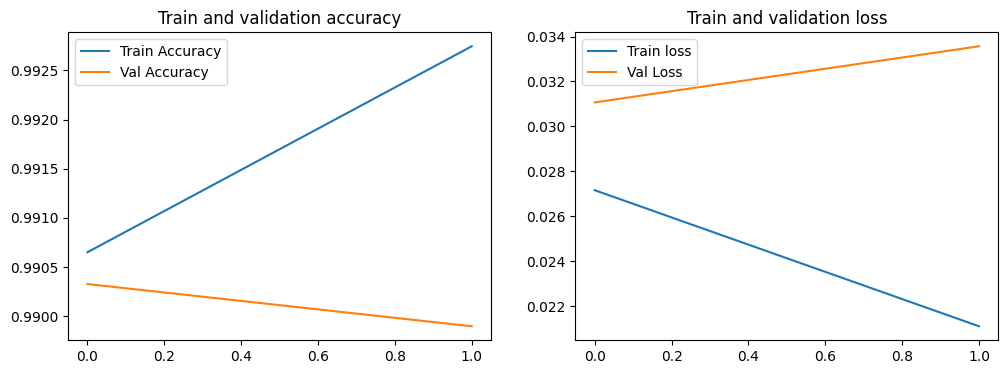

In [26]:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (12, 4))

epochs_range = range(EPOCHS)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = "Train Accuracy");
plt.plot(epochs_range, val_accuracy, label = "Val Accuracy");
plt.title("Train and validation accuracy");
# plt.xticks(epochs_range);
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = "Train loss");
plt.plot(epochs_range, val_loss, label = "Val Loss");
plt.title("Train and validation loss");
# plt.xticks(epochs_range, rotation = 90);
plt.legend();

### Check the predictions

In [27]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [33]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze([predicted_batch]).numpy()
predicted_ids = np.argmax(predicted_batch, axis = -1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 0s 31ms/step


array(['dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat',
       'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog',
       'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat',
       'dog', 'dog', 'cat', 'cat', 'dog'], dtype='<U3')

In [35]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1]
Predicted labels:  [1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1]


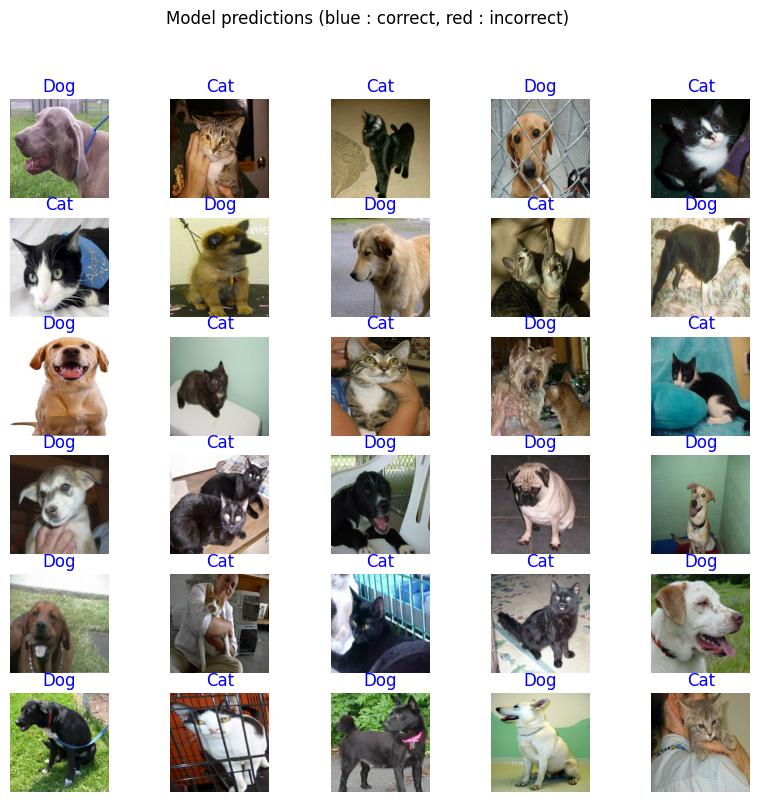

In [37]:
plt.figure(figsize = (10, 9))
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color = color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue : correct, red : incorrect)")